<a href="https://colab.research.google.com/github/Aldair1306/Modelos_de_difusion_en_grafos/blob/main/DifusionLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este notebook implementamos la simulación numérica de un modelo de difusión no conservativo en grafos no dirigidos y simples, que utiliza la matriz de Lerman-Ghosh en su estructura.

Sea $\chi$ un número real cualquiera, $I$ la matriz identidad y $A$ la matriz de adyacencia de un grafo. Definimos la matriz de Lerman-Ghosh como:

\begin{equation}
        \mathscr{L}_\chi=\chi I - A
\end{equation}

En donde $\chi$ es una constante.

La ecuación de difusión con esta matriz es la siguiente:

\begin{equation}
    \mathbf{\dot{C}}(t)=-\mathscr{L}_\chi\mathbf{C}(t)
\end{equation}

Donde:

* $C(t)$ es el vector de concentraciones; nos indica cuánta información tiene cierto nodo en un tiempo $t$.

* $\dot{C}(t)$ es el vector del cambio en las concentraciones del vector de concentraciones.

El comportamiento de las concentraciones con este modelo depende de la elección para el valor de $\chi$ y la magnitud del eigenvalor más grande del espectro de la matriz de adyacencia del grafo. Si denotamos por $\lambda_1$ al eigenvalor más grande de $A$ tenemos lo siguiente

*   Si $\chi$ > $\lambda_1$, las concentraciones tienden a cero.
*   Si $\chi$ < $\lambda_1$,las concentraciones tienden a infinito.
*   Si $\chi$ = $\lambda_1$, las concentraciones convergen.





In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [18]:
"""
La función recibe los siguientes parámetros:

A (Array de NumPy bidimensional): Matriz de adyacencia.
C0 (Array de NumPy unidimensional): Vector de concentraciones iniciales.
Tiempo (Entero positivo): Cantidad de tiempo que se desea simular.
Tolerancia (Número entero o float positivo): Tolerancia para el criterio de paro.
Semilla (Número entero positivo): Una semilla para reproducir resultados aleatorios.
K (Número positivo): Es un parámetro que sirve para la visualización, controla qué tan separados estarán los vértices al imprimir el grafo.
Escalar (True o False): Es un parámetro para la visualización 3D. Si es True, se plotea el grafo en 3D con las curvaturas sobre las aristas de tal forma que aparecen en una altura de 0 a 1. Si es False, aparecen por debajo de las aristas tan profundamente como el valor de la curvatura de esa arista.
chi (Número entero o float):  dependiendo de su magnitud, el proceso mostrará uno de tres comportamientos posibles.
"""

def DifusionLR(A,C0,Tiempo,Tolerancia,Semilla,K,Escalar,chi):

  #Obtenemos las etiquetas de los vertices usando la funcion Diccionario
  Etiquetas = Diccionario(len(C0))

  # Hacemos un grafo a partir de la matriz de adyacencia
  G = nx.convert_matrix.from_numpy_array(A)

  #Asignamos las etiquetas a los vertices
  G = nx.relabel_nodes(G, Etiquetas)

  #Obtenemos la matriz de incidencia para grafos no dirigidos
  B = nx.incidence_matrix(G, oriented=False).toarray()

  print("Eigenvalores de A: ")
  print(np.linalg.eigvals(A))


  #Creamos la matriz del modelo (Lerman-Ghosh)
  LR=A-chi*np.eye(len(C0))

  print("Matriz de Lerman-Ghosh:")
  print(LR)

  #Calculamos la matriz de incidencia
  Incidencia = nx.incidence_matrix(G, oriented=False).todense()

  #print("Matriz de incidencia")
  #print(Incidencia)

  #Enumeramos las aristas, edge nos regresara duplas tipo ('A','B') ('E','G'), con el indice i las enumeraremos alfabeticamente, hacemos esto para darle los nombres a las columnas de la tabla
  #de flujos que calculamos mas adelante
  aristas = {edge: f"{i+1}" for i, edge in enumerate(G.edges())}

  # Obtenemos los eigenvalores y eigenvectores
  eigenvalues, eigenvectors = np.linalg.eig(LR)

  #Información del espectro de la matriz de LR
  #print("Los eigenvalores ordenados de menor a mayor son :\n")
  #print(np.sort(eigenvalues))
  #print("Los eigenvectores son:")
  #print(eigenvectors)


  #Para presentar la evolución del proceso haremos un dataframe en donde el indice sea el tiempo y las columnas representen la cantidad de concentración en ese vertice.
  Evolucion = pd.DataFrame(columns=list(Etiquetas.values()))

  #Ahora definimos cuantos puntos en el intervalo de tiempo (0,Tiempo) queremos analizar, es decir, cuantos tiempos t dentro de ese intervalo usaremos para calcular
  #su respectivo C(t), como estamos en el caso continuo se recomienda que sean bastantes. Nosotros definimos por default 60 pero puede ajustarse
  S=60
  T = np.linspace(0, Tiempo, num=S)

  #Obtengo la inversa de la matriz de eigenvectores
  eigenvectorsInv=np.linalg.inv(eigenvectors)

  #Este for es el que simula el proceso, en cada t calculamos el vector C(t) y lo guardamos en su dataframe, usaremos tantas t como
  #hayamos definido o acabará antes si se considera que el proceso ya alcanzo un estado de equilibrio
  tolerancia=Tolerancia

  for t in T :
    #Inicializamos la matriz e^LR creando una matriz nula de tamaño |V| x |V|
    e_tL=np.zeros((len(C0),len(C0)))

    #Construimos la matriz exponencial con los eigenvalores multiplicandolos por la t en turno
    e_i=np.diag(np.exp(t*eigenvalues))

    #Construimos la matriz e^LR haciendo el producto de matrices
    e_tL=np.dot(np.dot(eigenvectors, e_i ),eigenvectorsInv)

    #Calculamos el vector C(t) multiplicando e^LR por C0 y lo guardamos
    Evolucion.loc[len(Evolucion)] = np.real(np.dot(e_tL,C0))

    #Enviamos a la funcion Criterio_Paro el vector C(t) y C(t-1) para ver si podemos detener el proceso. Hacemos esto para todas las iteraciones despues de la primera
    if t!=0 and Criterio_Paro(Evolucion.iloc[len(Evolucion)-1].to_numpy(),Evolucion.iloc[len(Evolucion)-2].to_numpy(),tolerancia):
      break



  #En esta seccion imprimimos la informacion resumida
  print("Vector de concentraciones inicial: ",C0)

  print("\nEvolucion del vector de concentraciones: \n")

  #Colocamos la columna tiempo como indice de la tabla
  Evolucion["Tiempo"]=T[:len(Evolucion)]
  Evolucion=Evolucion.set_index("Tiempo")
  print(Evolucion)

  #Mostramos la grafica de como fueron cambiando las concentraciones
  print("\nLa grafica es :")

  fig, axes = plt.subplots(1, 2, figsize=(16, 6))

  # --- Grafo ---
  pos = nx.spring_layout(G)
  nx.draw(G, pos, ax=axes[0], with_labels=True,
          node_color='lightblue', node_size=2000,
          edge_color='black', font_size=15, font_weight='bold')

  # --- Evolución de concentración ---
  Evolucion.plot(ax=axes[1])
  axes[1].set_xlabel('Tiempo')
  axes[1].set_ylabel('Concentración')
  axes[1].set_title('Evolución de concentración en el tiempo')
  axes[1].legend()
  axes[1].grid(True)

  plt.tight_layout()
  plt.show()

In [10]:
#Diremos que el proceso converge si cada una de las entradas del vector que resulta al resta C(t)-C(t-1) en valor absoluto
#es menor a la tolerancia dada
def Criterio_Paro(V1,V2,Tol):
  if np.all(np.abs(V1-V2)<Tol):
    return True
  return False

In [11]:
import string

#Aqui hacemos un diccionario en el que hacemos la relacion de cada letra con su posicion en el abecedario
def Diccionario(num_letters):
    # Obtener las letras del alfabeto en mayúsculas
    letters = string.ascii_uppercase

    # Verificar que el número de letras no exceda el número total de letras disponibles
    if num_letters > len(letters):
        raise ValueError(f"El número de letras solicitado ({num_letters}) excede el total disponible ({len(letters)})")

    # Crear el diccionario con las letras y los valores
    letter_dict = {letters[i]: i  for i in range(num_letters)}

    inverted_dict = {value: key for key, value in letter_dict.items()}

    return inverted_dict

#Difusion conservativa (Tiempo continuo)

Eigenvalores de A: 
[ 3.33638192e+00  1.83055899e+00  1.50303193e+00  8.10371495e-01
 -2.24557711e+00 -1.93680707e+00 -1.43850891e+00 -8.59451257e-01
  8.53981326e-18 -1.00000000e+00]
Matriz de Lerman-Ghosh:
[[-3.33638192  1.          0.          0.          1.          0.
   0.          0.          1.          1.        ]
 [ 1.         -3.33638192  1.          0.          1.          1.
   0.          0.          0.          0.        ]
 [ 0.          1.         -3.33638192  1.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          1.         -3.33638192  0.          0.
   1.          0.          0.          0.        ]
 [ 1.          1.          0.          0.         -3.33638192  1.
   0.          0.          0.          1.        ]
 [ 0.          1.          0.          0.          1.         -3.33638192
   1.          0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          1.
  -3.33638192  1

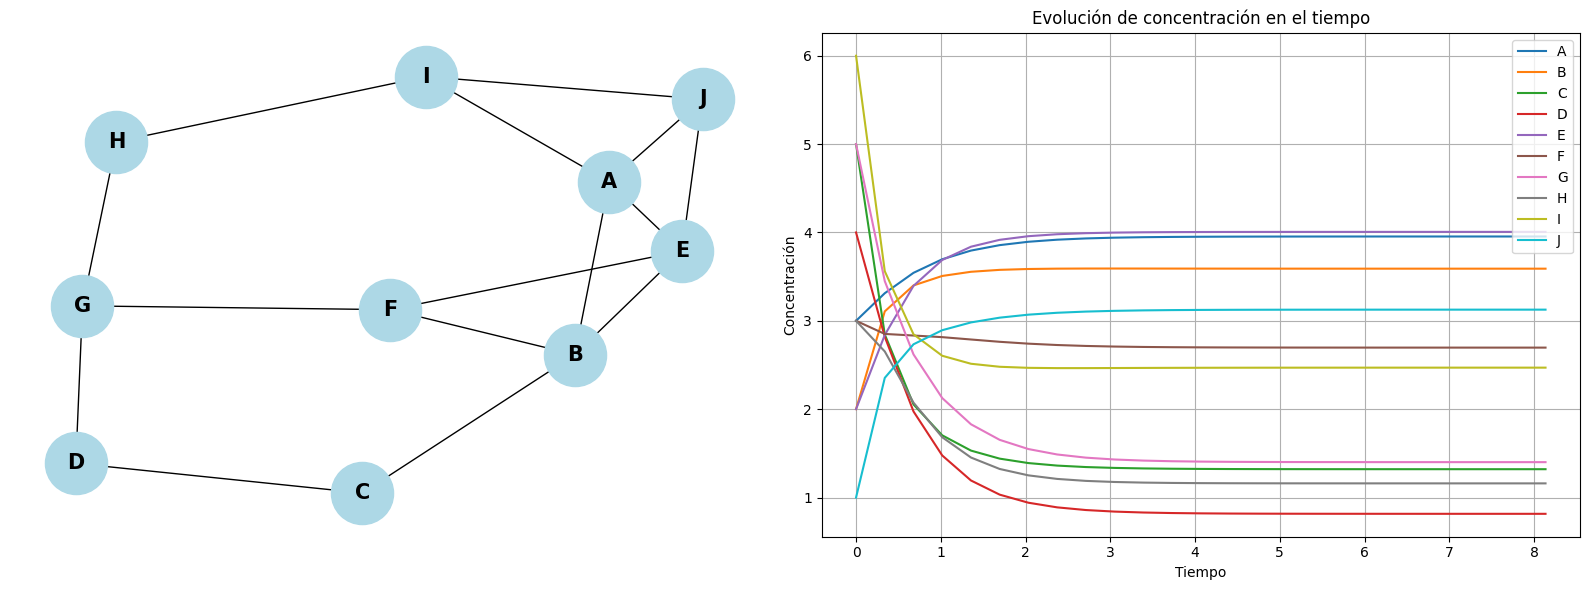

Eigenvalores de A: 
[ 3.33638192e+00  1.83055899e+00  1.50303193e+00  8.10371495e-01
 -2.24557711e+00 -1.93680707e+00 -1.43850891e+00 -8.59451257e-01
  8.53981326e-18 -1.00000000e+00]
Matriz de Lerman-Ghosh:
[[-3.23638192  1.          0.          0.          1.          0.
   0.          0.          1.          1.        ]
 [ 1.         -3.23638192  1.          0.          1.          1.
   0.          0.          0.          0.        ]
 [ 0.          1.         -3.23638192  1.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          1.         -3.23638192  0.          0.
   1.          0.          0.          0.        ]
 [ 1.          1.          0.          0.         -3.23638192  1.
   0.          0.          0.          1.        ]
 [ 0.          1.          0.          0.          1.         -3.23638192
   1.          0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          1.
  -3.23638192  1

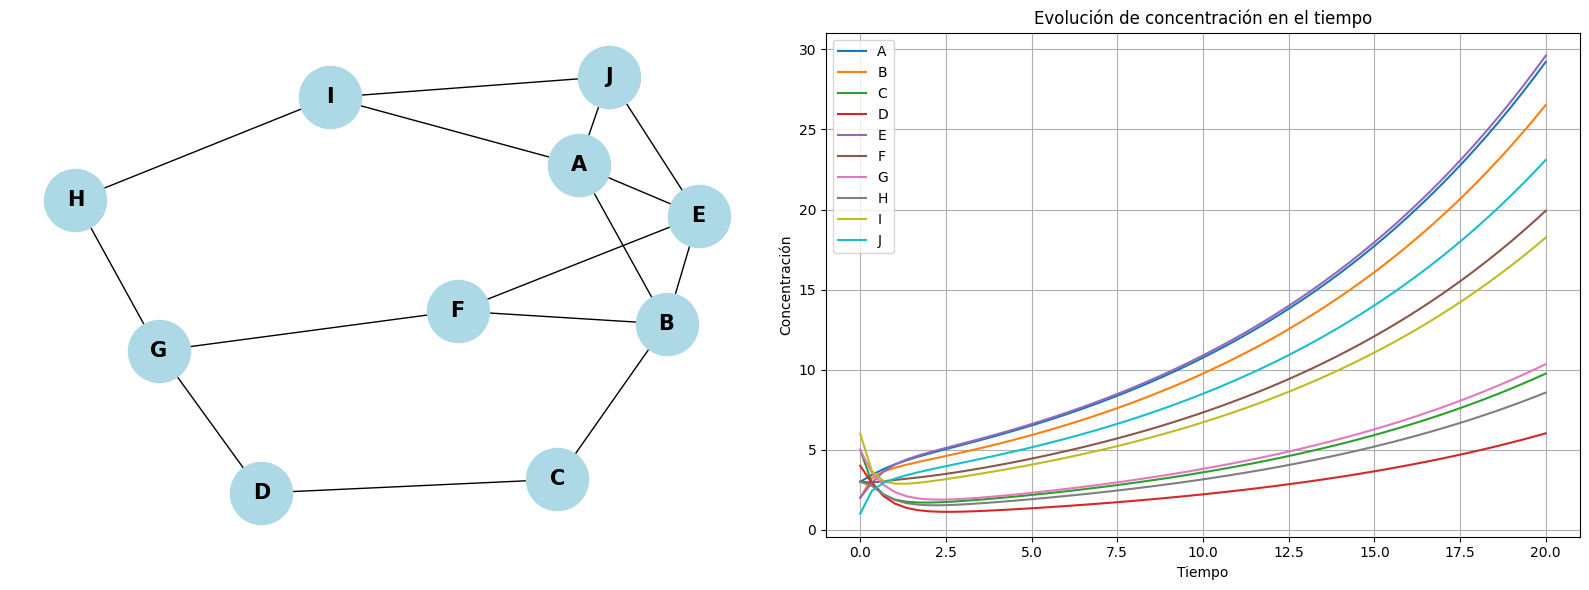

Eigenvalores de A: 
[ 3.33638192e+00  1.83055899e+00  1.50303193e+00  8.10371495e-01
 -2.24557711e+00 -1.93680707e+00 -1.43850891e+00 -8.59451257e-01
  8.53981326e-18 -1.00000000e+00]
Matriz de Lerman-Ghosh:
[[-3.43638192  1.          0.          0.          1.          0.
   0.          0.          1.          1.        ]
 [ 1.         -3.43638192  1.          0.          1.          1.
   0.          0.          0.          0.        ]
 [ 0.          1.         -3.43638192  1.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          1.         -3.43638192  0.          0.
   1.          0.          0.          0.        ]
 [ 1.          1.          0.          0.         -3.43638192  1.
   0.          0.          0.          1.        ]
 [ 0.          1.          0.          0.          1.         -3.43638192
   1.          0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          1.
  -3.43638192  1

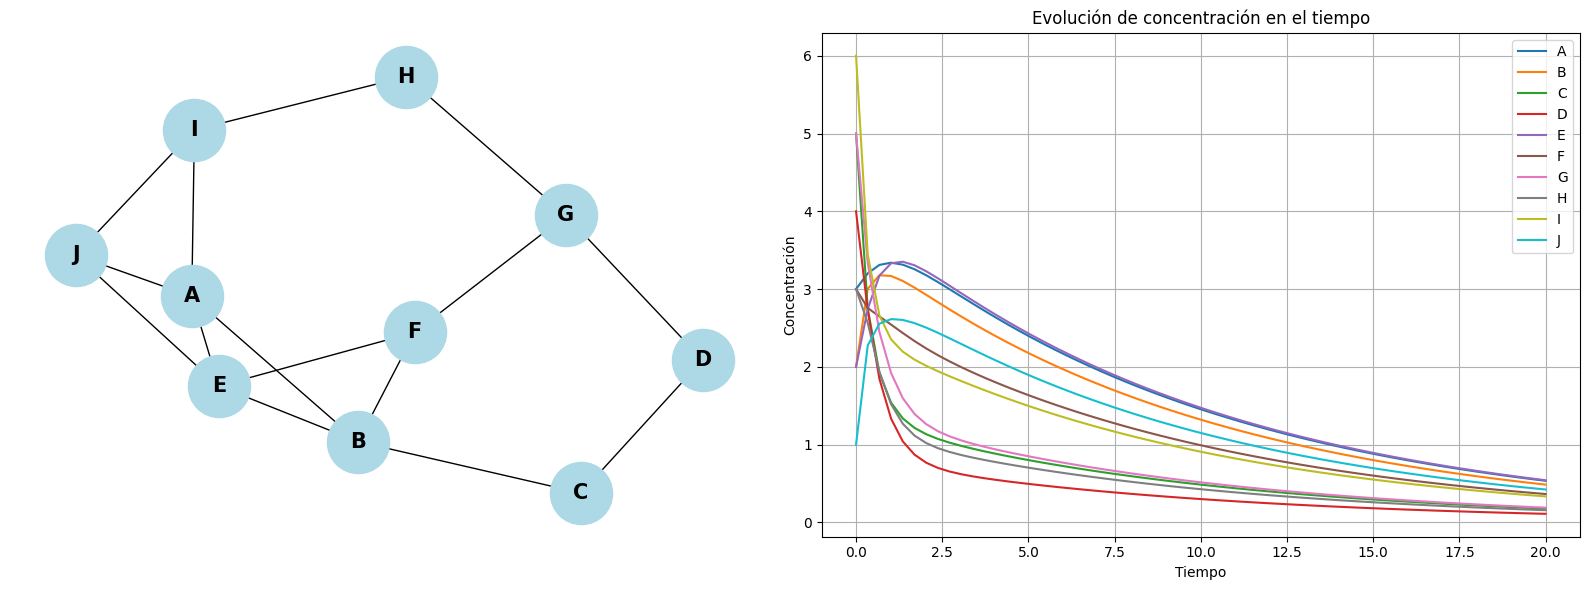

In [23]:
A = np.array([
    [0, 1, 0, 0, 1, 0, 0, 0, 1, 1],
    [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [1, 1, 0, 0, 0, 1, 0, 0, 0, 1],
    [0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
    [1, 0, 0, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 1, 0]
])

C0=np.array([3,2,5,4,2,3,5,3,6,1])
#C0=np.array([0,0,0,0,0,0,0,0,0,20])
Tolerancia=0.00001
Tiempo=20
Semilla=1
chi=3.33638192

#Caso en el que chi es igual al eigenvalor mas grande de A
DifusionLR(A,C0,Tiempo,Tolerancia,Semilla,0.2,True,chi)

#Caso en el que chi es menor al eigenvalor mas grande que A
DifusionLR(A,C0,Tiempo,Tolerancia,Semilla,0.2,True,chi-0.1)

#Caso en el que chi es menor al eigenvalor mas grande que A
DifusionLR(A,C0,Tiempo,Tolerancia,Semilla,0.2,True,chi+0.1)

Eigenvalores de A: 
[ 2.68554393e+00  3.34903985e-01 -1.27133037e+00 -1.74911755e+00
  9.36366736e-18]
Matriz de Lerman-Ghosh:
[[-2.68554393  1.          1.          0.          1.        ]
 [ 1.         -2.68554393  1.          1.          1.        ]
 [ 1.          1.         -2.68554393  0.          0.        ]
 [ 0.          1.          0.         -2.68554393  0.        ]
 [ 1.          1.          0.          0.         -2.68554393]]
Vector de concentraciones inicial:  [10  8  6  5  4]

Evolucion del vector de concentraciones: 

                  A         B         C         D         E
Tiempo                                                     
0.000000  10.000000  8.000000  6.000000  5.000000  4.000000
0.508475   8.127978  8.732365  6.282634  3.650707  5.772144
1.016949   7.919625  8.802016  6.249927  3.368916  6.119627
1.525424   7.904246  8.801831  6.229170  3.301097  6.195912
2.033898   7.905944  8.798833  6.222601  3.282964  6.214112
2.542373   7.907305  8.797522  6.220861 

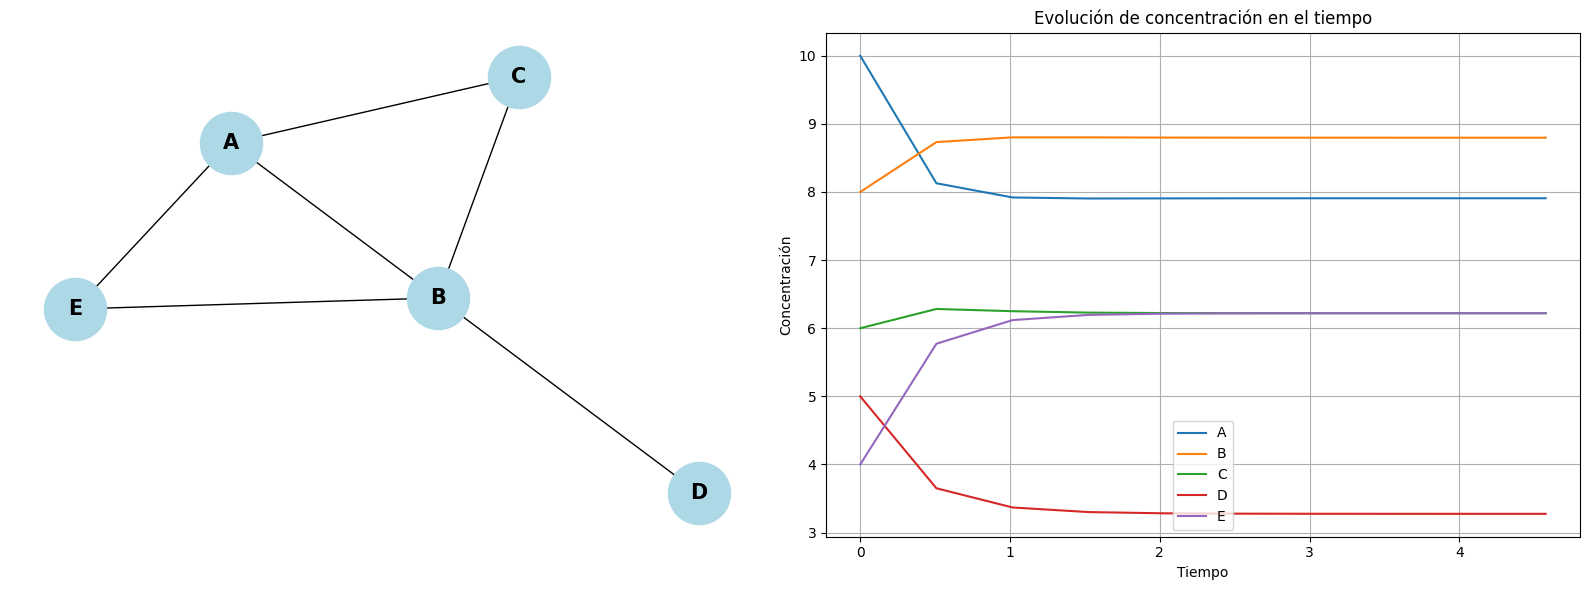

Eigenvalores de A: 
[ 2.68554393e+00  3.34903985e-01 -1.27133037e+00 -1.74911755e+00
  9.36366736e-18]
Matriz de Lerman-Ghosh:
[[-2.58554393  1.          1.          0.          1.        ]
 [ 1.         -2.58554393  1.          1.          1.        ]
 [ 1.          1.         -2.58554393  0.          0.        ]
 [ 0.          1.          0.         -2.58554393  0.        ]
 [ 1.          1.          0.          0.         -2.58554393]]
Vector de concentraciones inicial:  [10  8  6  5  4]

Evolucion del vector de concentraciones: 

                    A           B           C          D           E
Tiempo                                                              
0.000000    10.000000    8.000000    6.000000   5.000000    4.000000
0.508475     8.551952    9.187866    6.610352   3.841137    6.073233
1.016949     8.767387    9.744234    6.918955   3.729544    6.774707
1.525424     9.206801   10.252301    7.255686   3.845091    7.216947
2.033898     9.689131   10.783411    7.626109 

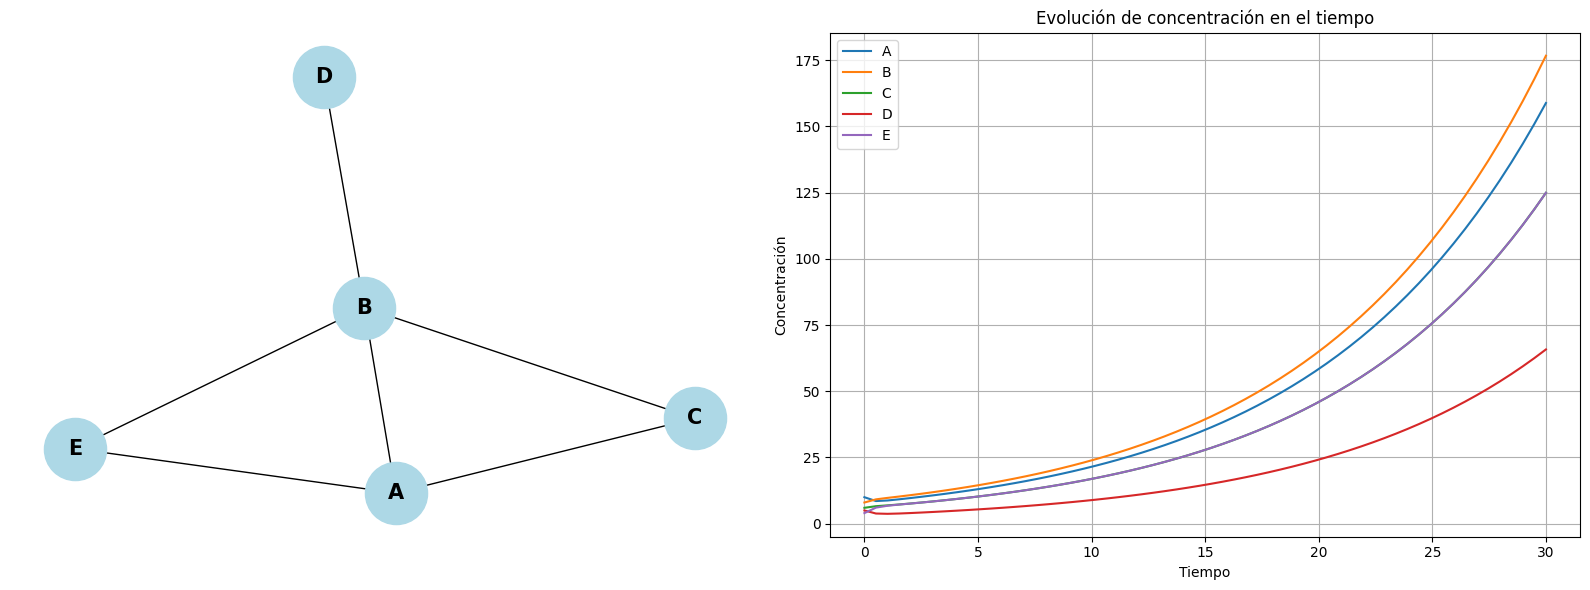

Eigenvalores de A: 
[ 2.68554393e+00  3.34903985e-01 -1.27133037e+00 -1.74911755e+00
  9.36366736e-18]
Matriz de Lerman-Ghosh:
[[-2.78554393  1.          1.          0.          1.        ]
 [ 1.         -2.78554393  1.          1.          1.        ]
 [ 1.          1.         -2.78554393  0.          0.        ]
 [ 0.          1.          0.         -2.78554393  0.        ]
 [ 1.          1.          0.          0.         -2.78554393]]
Vector de concentraciones inicial:  [10  8  6  5  4]

Evolucion del vector de concentraciones: 

                   A         B         C         D         E
Tiempo                                                      
0.000000   10.000000  8.000000  6.000000  5.000000  4.000000
0.508475    7.725022  8.299446  5.971164  3.469719  5.485982
1.016949    7.153838  7.950906  5.645591  3.043159  5.527890
1.525424    6.785973  7.556570  5.347883  2.834066  5.319330
2.033898    6.450935  7.179497  5.077394  2.678767  5.070467
2.542373    6.132176  6.822546  4

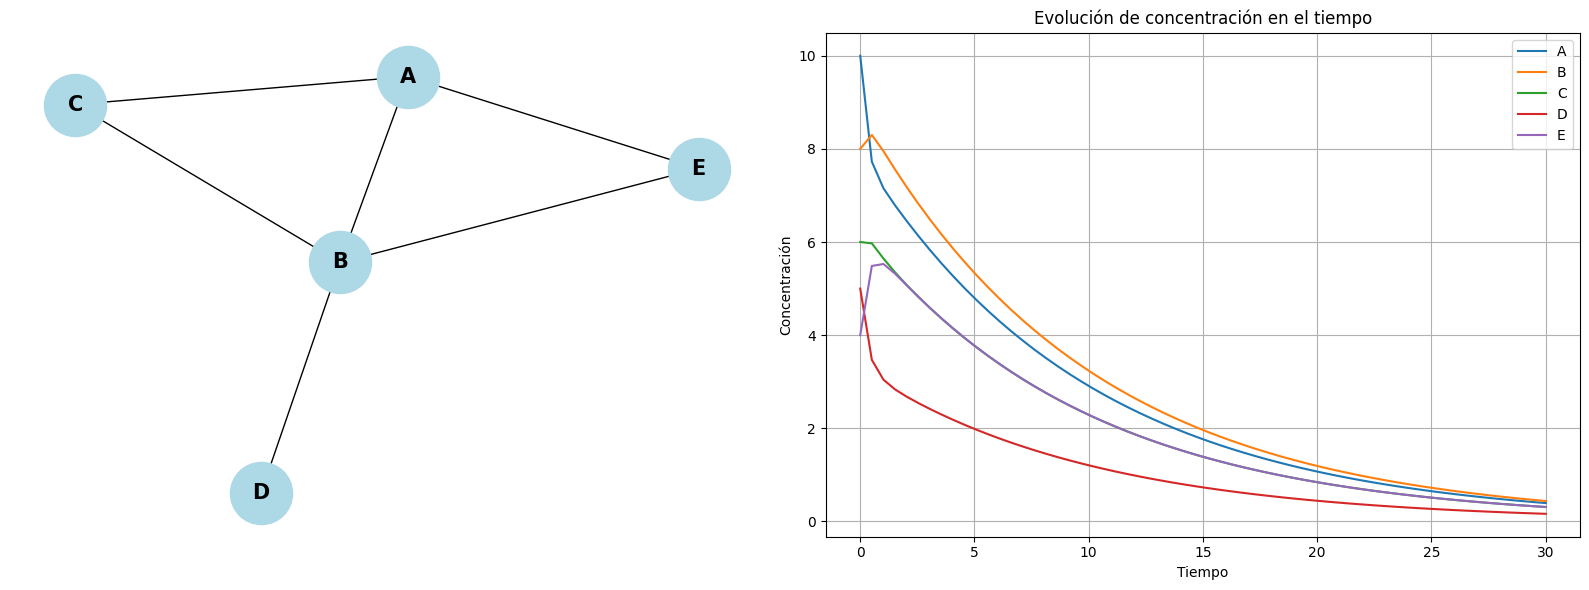

In [25]:
# Definir la matriz A
A = np.array([
    [0,1,1,0,1],
    [1,0,1,1,1],
    [1,1,0,0,0],
    [0,1,0,0,0],
    [1,1,0,0,0],
])

C0=np.array([10,8,6,5,4])
Tolerancia=0.0001
Tiempo=30
chi=2.68554393

#Caso en el que chi es igual al eigenvalor mas grande de A
DifusionLR(A,C0,Tiempo,Tolerancia,2,0.2,True,chi)

#Caso en el que chi es menor al eigenvalor mas grande que A
DifusionLR(A,C0,Tiempo,Tolerancia,2,0.2,True,chi-0.1)

#Caso en el que chi es mayor al eigenvalor mas grande que A
DifusionLR(A,C0,Tiempo,Tolerancia,2,0.2,True,chi+0.1)